# Example submission for the Zindi hackathon, 12 October 2019

### I threw this together quickly so that it's possible for folks to get a submission on the leaderboard as rapidly as possible without getting bogged down in data wrangling. I hope it's useful!

There is all sorts of ways you can improve on the model shown here - the object is for this to be a starting point for anyone feeling like they don't know where to begin.

I apologise for the hacky data-shaping. Feel free to share your own improved versions :)

# Loading the data

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# We'll generate this later, so don't download it if you're in a hurry
sample_sub = pd.read_csv('SampleSubmission.csv');sample_sub.head()

,datetime x segment_id,prediction
0,2019-01-01 01:00:00 x S0B3CGQ,NaN
1,2019-01-01 01:00:00 x RYJYAPI,NaN
2,2019-01-01 01:00:00 x U3KP57C,NaN
3,2019-01-01 01:00:00 x RY0TRQ8,NaN
4,2019-01-01 01:00:00 x 8LOVJZ3,NaN


In [3]:
# Make sure train is in the folder where this notebook is running
data = pd.read_csv('train.csv', 
                   parse_dates = ['Occurrence Local Date Time'])
data.head()

,EventId,Occurrence Local Date Time,Reporting Agency,Cause,Subcause,Status,longitude,latitude,road_segment_id
0,60558,2016-01-01 00:53:00,Cam,Stationary Vehicle,Vehicle On Shoulder,Closed,18.5408955032,-33.888275,S0B3CGQ
1,60559,2016-01-01 00:54:00,CAMERA,Accident,With A Fixed Object,Closed,18.9307563219,-34.140857,RYJYAPI
2,60560,2016-01-01 02:26:00,Law Enforcement,Accident,Multi Vehicle,Closed,18.5533575029,-33.959154,U3KP57C
3,60561,2016-01-01 02:56:00,CAMERA,Stationary Vehicle,Vehicle On Shoulder,Closed,18.6775561589,-33.895258,RY0TRQ8
4,60562,2016-01-01 03:40:00,CAMERA,Accident,Multi Vehicle,Closed,18.8371319682,-34.087051,8LOVJZ3


In [4]:
data.dtypes

EventId                                int64
Occurrence Local Date Time    datetime64[ns]
Reporting Agency                      object
Cause                                 object
Subcause                              object
Status                                object
longitude                             object
latitude                             float64
road_segment_id                       object
dtype: object

In [5]:
data = data.drop("Status", axis=1)

In [6]:
data.dtypes

EventId                                int64
Occurrence Local Date Time    datetime64[ns]
Reporting Agency                      object
Cause                                 object
Subcause                              object
longitude                             object
latitude                             float64
road_segment_id                       object
dtype: object

In [7]:
data["longitude"] = pd.to_numeric(data.longitude, errors='coerce')

In [8]:
data.dtypes

EventId                                int64
Occurrence Local Date Time    datetime64[ns]
Reporting Agency                      object
Cause                                 object
Subcause                              object
longitude                            float64
latitude                             float64
road_segment_id                       object
dtype: object

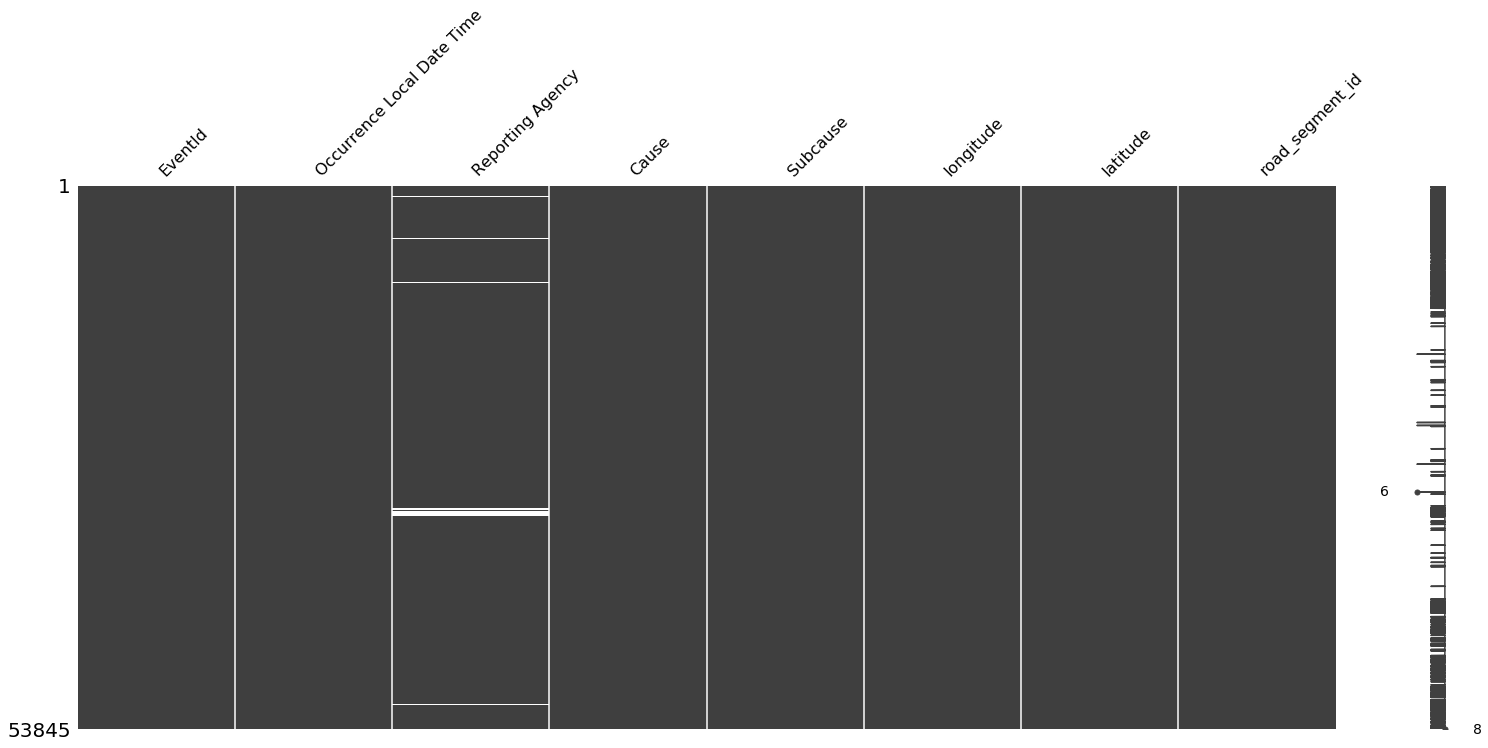

In [9]:
import missingno as msno
msno.matrix(data)

In [10]:
data['road_segment_id'].unique().shape

(549,)

# We want train and test arrays that match the sample submission.

### Don't bother reading too closely - check the output and move on. I did this so you don't have to!

First, we split by date. Here I'm using only 2017 for training, and part of 2018 for local testing.

In [11]:
# Train on 2017
train = data.loc[data['Occurrence Local Date Time'] < '2018-01-01']
train = train.loc[train['Occurrence Local Date Time'] >= '2017-01-01']

# Test locally on the last part of 2018
local_test = data.loc[data['Occurrence Local Date Time'] < '2019-01-01']
local_test = local_test.loc[local_test['Occurrence Local Date Time'] >= '2018-09-01']

Now we need to reshape these. 

In [12]:
# Create a dataframe with a column for each segment_id (sid)
# Each row represents an hour.

sids = data['road_segment_id'].unique()

dts = pd.date_range('2017-01-01',
                    '2018-01-01',
                    freq="1h")
tr = pd.DataFrame({'datetime':dts})

for sid in sids:
    tr[str(sid)] = 0
    events = train.loc[train['road_segment_id'] == sid]
    dts = events['Occurrence Local Date Time'].dt.round('H')
    dates = dts.astype(str).unique()
    tr.loc[tr['datetime'].isin(dates), sid] = 1
tr.head()

,datetime,S0B3CGQ,RYJYAPI,U3KP57C,RY0TRQ8,8LOVJZ3,X4UA382,0QR8FDW,DZABHQW,EKZN1VM,...,YVR8GT6,ZAVM3PJ,DS4NLQE,HR19LL7,1451FOG,2ON8NSO,NFUEAN5,4T821GV,J6A19TW,43RCYZH
0,2017-01-01 00:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2017-01-01 01:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2017-01-01 02:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2017-01-01 03:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2017-01-01 04:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# Reshape this as in sample submission
# I add some extra columns that may be useful
train = pd.DataFrame({
    'datetime x segment_id':np.concatenate([[str(x) + " x " + str(c) 
                                             for c in sids] 
                                            for x in tr['datetime']]),
    'datetime':np.concatenate([[str(x) for c in sids] for x in tr['datetime']]),
    'segment_id':np.concatenate([[str(c) for c in sids] for x in tr['datetime']]),
    'y':tr[sids].values.flatten()
})
train.head()

,datetime x segment_id,datetime,segment_id,y
0,2017-01-01 00:00:00 x S0B3CGQ,2017-01-01 00:00:00,S0B3CGQ,0
1,2017-01-01 00:00:00 x RYJYAPI,2017-01-01 00:00:00,RYJYAPI,0
2,2017-01-01 00:00:00 x U3KP57C,2017-01-01 00:00:00,U3KP57C,0
3,2017-01-01 00:00:00 x RY0TRQ8,2017-01-01 00:00:00,RY0TRQ8,0
4,2017-01-01 00:00:00 x 8LOVJZ3,2017-01-01 00:00:00,8LOVJZ3,0


In [14]:
# Same for local test (test from now on)
dts = pd.date_range('2018-09-01','2018-12-31',
                    freq="1h")
tr = pd.DataFrame({'datetime':dts})

for sid in sids:
    tr[str(sid)] = 0
    events = local_test.loc[local_test['road_segment_id'] == sid]
    dts = events['Occurrence Local Date Time'].dt.round('H')
    dates = dts.astype(str).unique()
    tr.loc[tr['datetime'].isin(dates), sid] = 1
    
test = pd.DataFrame({
    'datetime x segment_id':np.concatenate([[str(x) + " x " + str(c) 
                                             for c in sids] 
                                            for x in tr['datetime']]),
    'datetime':np.concatenate([[str(x) for c in sids] for x in tr['datetime']]),
    'segment_id':np.concatenate([[str(c) for c in sids] for x in tr['datetime']]),
    'y':tr[sids].values.flatten()
})
test.head()

,datetime x segment_id,datetime,segment_id,y
0,2018-09-01 00:00:00 x S0B3CGQ,2018-09-01 00:00:00,S0B3CGQ,0
1,2018-09-01 00:00:00 x RYJYAPI,2018-09-01 00:00:00,RYJYAPI,0
2,2018-09-01 00:00:00 x U3KP57C,2018-09-01 00:00:00,U3KP57C,0
3,2018-09-01 00:00:00 x RY0TRQ8,2018-09-01 00:00:00,RY0TRQ8,0
4,2018-09-01 00:00:00 x 8LOVJZ3,2018-09-01 00:00:00,8LOVJZ3,0


In [15]:
train.y.sum()

14234

# Now that we have these, what features can we add?

All we have to go on is the date and segment ID. The shapefile of road segments has info on road type etc. We could get location for the segments, and use the uber movement data to add traffic speed for that area. Finally, we can do date-related values. I'll do the third first as it's a nice easy way to get something.

In [16]:
train['datetime'] = pd.to_datetime(train['datetime'])
train['day'] = train['datetime'].dt.day_name()

In [17]:
train['min'] = train['datetime'].dt.hour*60+train['datetime'].dt.minute
train.head()

,datetime x segment_id,datetime,segment_id,y,day,min
0,2017-01-01 00:00:00 x S0B3CGQ,2017-01-01,S0B3CGQ,0,Sunday,0
1,2017-01-01 00:00:00 x RYJYAPI,2017-01-01,RYJYAPI,0,Sunday,0
2,2017-01-01 00:00:00 x U3KP57C,2017-01-01,U3KP57C,0,Sunday,0
3,2017-01-01 00:00:00 x RY0TRQ8,2017-01-01,RY0TRQ8,0,Sunday,0
4,2017-01-01 00:00:00 x 8LOVJZ3,2017-01-01,8LOVJZ3,0,Sunday,0


In [25]:
locations = data.groupby('road_segment_id').mean()[['longitude', 'latitude']]
locations.head(2)

# MY COMMENT - that does not look right (why is longitude in the road_segment_id)

,longitude,latitude
road_segment_id,,
-33.8891283413,NaN,18.614566
-33.9622761744,NaN,18.564216


longitude    18.604685
latitude    -33.947960
dtype: float64

In [26]:
train = pd.merge(train, locations, left_on='segment_id', right_on='road_segment_id')
train.head()

,datetime x segment_id,datetime,segment_id,y,day,min,longitude,latitude
0,2017-01-01 00:00:00 x S0B3CGQ,2017-01-01 00:00:00,S0B3CGQ,0,Sunday,0,18.541422,-33.888613
1,2017-01-01 01:00:00 x S0B3CGQ,2017-01-01 01:00:00,S0B3CGQ,0,Sunday,60,18.541422,-33.888613
2,2017-01-01 02:00:00 x S0B3CGQ,2017-01-01 02:00:00,S0B3CGQ,0,Sunday,120,18.541422,-33.888613
3,2017-01-01 03:00:00 x S0B3CGQ,2017-01-01 03:00:00,S0B3CGQ,0,Sunday,180,18.541422,-33.888613
4,2017-01-01 04:00:00 x S0B3CGQ,2017-01-01 04:00:00,S0B3CGQ,0,Sunday,240,18.541422,-33.888613


In [27]:
train.tail()

,datetime x segment_id,datetime,segment_id,y,day,min,longitude,latitude
4809784,2017-12-31 20:00:00 x 43RCYZH,2017-12-31 20:00:00,43RCYZH,0,Sunday,1200,19.12523,-33.726606
4809785,2017-12-31 21:00:00 x 43RCYZH,2017-12-31 21:00:00,43RCYZH,0,Sunday,1260,19.12523,-33.726606
4809786,2017-12-31 22:00:00 x 43RCYZH,2017-12-31 22:00:00,43RCYZH,0,Sunday,1320,19.12523,-33.726606
4809787,2017-12-31 23:00:00 x 43RCYZH,2017-12-31 23:00:00,43RCYZH,0,Sunday,1380,19.12523,-33.726606
4809788,2018-01-01 00:00:00 x 43RCYZH,2018-01-01 00:00:00,43RCYZH,0,Monday,0,19.12523,-33.726606


Cleaning up some things we don't need to save RAM

In [28]:
data, local_test = 0, 0

# Creating and training a model

I like CatBoost because you don't have to do much to get a decent set of predictions. Categorical columns are easy to deal with and it doesn't take hours to train. THat said, use whatever you like here!

In [30]:
train.dtypes

datetime x segment_id            object
datetime                 datetime64[ns]
segment_id                       object
y                                 int64
day                              object
min                               int64
longitude                       float64
latitude                        float64
dtype: object

In [31]:
from catboost import CatBoostClassifier

# Create the model
model = CatBoostClassifier(iterations=20, 
                           loss_function='Logloss', 
                           verbose=False) 

x_cols = ['day', 'segment_id', 'min', 'longitude', 'latitude']
cat_cols = ['day', 'segment_id']

model.fit(train[x_cols], train['y'], cat_features=cat_cols) # MY COMMENT: omg, after 3 hours it actually worked

# Scoring the model

We'll start by looking at log-loss, then switch to trying to get a reasonable F1 score.

In [40]:
# Score the model on the train set
from sklearn.metrics import log_loss
log_loss(train['y'], model.predict_proba(train[x_cols])[:, 1])

0.017694947594038366

In [41]:
# Is this better than just 0s?
log_loss(train['y'], [0 for y in train['y']]) #yes!

0.10221341169127417

In [50]:
# Pre-process the test to match train
test['datetime'] = pd.to_datetime(test['datetime'])
test['day'] = test['datetime'].dt.day_name()
test['min'] = test['datetime'].dt.hour*60+test['datetime'].dt.minute
test = pd.merge(test, locations, left_on='segment_id', right_on='road_segment_id')

test.head()

,datetime x segment_id,datetime,segment_id,y,day,min,longitude_x,latitude_x,longitude_y,latitude_y,longitude_x,latitude_x,longitude_y,latitude_y,longitude,latitude
0,2018-09-01 00:00:00 x S0B3CGQ,2018-09-01 00:00:00,S0B3CGQ,0,Saturday,0,18.541422,-33.888613,18.541422,-33.888613,18.541422,-33.888613,18.541422,-33.888613,18.541422,-33.888613
1,2018-09-01 01:00:00 x S0B3CGQ,2018-09-01 01:00:00,S0B3CGQ,0,Saturday,60,18.541422,-33.888613,18.541422,-33.888613,18.541422,-33.888613,18.541422,-33.888613,18.541422,-33.888613
2,2018-09-01 02:00:00 x S0B3CGQ,2018-09-01 02:00:00,S0B3CGQ,0,Saturday,120,18.541422,-33.888613,18.541422,-33.888613,18.541422,-33.888613,18.541422,-33.888613,18.541422,-33.888613
3,2018-09-01 03:00:00 x S0B3CGQ,2018-09-01 03:00:00,S0B3CGQ,0,Saturday,180,18.541422,-33.888613,18.541422,-33.888613,18.541422,-33.888613,18.541422,-33.888613,18.541422,-33.888613
4,2018-09-01 04:00:00 x S0B3CGQ,2018-09-01 04:00:00,S0B3CGQ,0,Saturday,240,18.541422,-33.888613,18.541422,-33.888613,18.541422,-33.888613,18.541422,-33.888613,18.541422,-33.888613


In [47]:
train.head()

,datetime x segment_id,datetime,segment_id,y,day,min,longitude,latitude
0,2017-01-01 00:00:00 x S0B3CGQ,2017-01-01 00:00:00,S0B3CGQ,0,Sunday,0,18.541422,-33.888613
1,2017-01-01 01:00:00 x S0B3CGQ,2017-01-01 01:00:00,S0B3CGQ,0,Sunday,60,18.541422,-33.888613
2,2017-01-01 02:00:00 x S0B3CGQ,2017-01-01 02:00:00,S0B3CGQ,0,Sunday,120,18.541422,-33.888613
3,2017-01-01 03:00:00 x S0B3CGQ,2017-01-01 03:00:00,S0B3CGQ,0,Sunday,180,18.541422,-33.888613
4,2017-01-01 04:00:00 x S0B3CGQ,2017-01-01 04:00:00,S0B3CGQ,0,Sunday,240,18.541422,-33.888613


In [51]:
# The important score
log_loss(test['y'], model.predict_proba(test[x_cols])[:, 1])

# I cried at that point

0.03156051877607546

### Now the hard part. Zindi wants binary predictions for the F1 score, but all our probabilities are low. Still, our F1 score will be 0 if we predict all 0s, so we need to pick a threshold that gives some 1s. Let's try a few things

In [52]:
# First, just using .predict
from sklearn.metrics import f1_score
f1_score(test['y'], model.predict(test[x_cols]))

0.0

In [53]:
# Let's predict 1 even if the prob is just > 0.005
test['pred'] = model.predict_proba(test[x_cols])[:,1]
test['gt005'] = (test['pred']>0.005).astype(int)
test.head()

,datetime x segment_id,datetime,segment_id,y,day,min,longitude_x,latitude_x,longitude_y,latitude_y,longitude_x,latitude_x,longitude_y,latitude_y,longitude,latitude,pred,gt005
0,2018-09-01 00:00:00 x S0B3CGQ,2018-09-01 00:00:00,S0B3CGQ,0,Saturday,0,18.541422,-33.888613,18.541422,-33.888613,18.541422,-33.888613,18.541422,-33.888613,18.541422,-33.888613,0.011438,1
1,2018-09-01 01:00:00 x S0B3CGQ,2018-09-01 01:00:00,S0B3CGQ,0,Saturday,60,18.541422,-33.888613,18.541422,-33.888613,18.541422,-33.888613,18.541422,-33.888613,18.541422,-33.888613,0.001369,0
2,2018-09-01 02:00:00 x S0B3CGQ,2018-09-01 02:00:00,S0B3CGQ,0,Saturday,120,18.541422,-33.888613,18.541422,-33.888613,18.541422,-33.888613,18.541422,-33.888613,18.541422,-33.888613,0.001369,0
3,2018-09-01 03:00:00 x S0B3CGQ,2018-09-01 03:00:00,S0B3CGQ,0,Saturday,180,18.541422,-33.888613,18.541422,-33.888613,18.541422,-33.888613,18.541422,-33.888613,18.541422,-33.888613,0.001369,0
4,2018-09-01 04:00:00 x S0B3CGQ,2018-09-01 04:00:00,S0B3CGQ,0,Saturday,240,18.541422,-33.888613,18.541422,-33.888613,18.541422,-33.888613,18.541422,-33.888613,18.541422,-33.888613,0.001369,0


In [54]:
f1_score(test['y'], test['gt005'])

0.03374042196990835

In [55]:
# WHat about an even lower threshold?
test['gt0005'] = (test['pred']>0.0005).astype(int)
f1_score(test['y'], test['gt0005'])

0.012434894455878524

In [56]:
# Hmm. And a higher 1?
test['gt05'] = (test['pred']>0.05).astype(int)
f1_score(test['y'], test['gt05'])

# Omg it's actually better! Need to get closer to 1.

0.047669577993633167

There are better ways to do this than picking randomly. Hint: look at how often events occur on average, or just do a search for the best.

# Making a submission

This is where you generate something that can be uploaded to Zindi to get a score. These are big files, so don't do this often - work with local tests until you really have an improvement before you tax their poor server.

In [ ]:
# Make the dataframe - dates based on sample submission file
dts = pd.date_range('2019-01-01 01:00:00',
                    '2019-03-31 23:00:00',
                    freq="1h")
tr = pd.DataFrame({'datetime':dts})

for sid in sids:
    tr[str(sid)] = 0
    
ss = pd.DataFrame({
    'datetime x segment_id':np.concatenate([[str(x) + " x " + str(c)  
                                            for x in tr['datetime']for c in sids]]),
    'datetime':np.concatenate([[str(x) for x in tr['datetime']for c in sids]]),
    'segment_id':np.concatenate([[str(c) for x in tr['datetime']for c in sids]])
})
ss.head()

In [ ]:
# Add the extra features
ss['datetime'] = pd.to_datetime(ss['datetime'])
ss['day'] = ss['datetime'].dt.weekday_name
ss['min'] = ss['datetime'].dt.hour*60+ss['datetime'].dt.minute
ss = pd.merge(ss, locations, left_on='segment_id', right_on='road_segment_id', how='left')
ss['prediction'] = 0
ss.head()

In [ ]:
# Make predictions
ss['prediction'] = model.predict_proba(ss[x_cols])[:, 1] 
ss.head()

In [ ]:
# Changing to binary with our threshold:
ss['prediction'] = (ss['prediction']>0.05).astype(int)

In [ ]:
ss.head()

In [ ]:
ss.shape

In [ ]:
# Save to CSV and submit
ss[['datetime x segment_id', 'prediction']].to_csv('starter_notebook.csv', index=False)

### And that's it. Tweak things here and test locally - don't waste time constantly submitting and waiting on Zindi's score. Some suggested Improvements:



*   Add more features. The roads shapefile has some juicy details on number of lanes, road conditions...
*   Use Uber Movement. You can get travel times to neighbouring areas for the locations of each segment. Might be useful!
*   Tweak the model. Look at ways to deal with imbalanced data.
*   Train on all the available data (not just 2017 as in this example)

Good luck :)



